In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from tensorflow.keras import layers, models, callbacks

In [28]:
np.random.seed(3888)
tf.random.set_seed(3888)

In [29]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_0.csv")

In [ ]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create liquidity, micro‑structure and realised‑volatility features."""
    # --- Level‑1 mid‑price & spread
    df["mid_price"] = (df["bid_price1"] + df["ask_price1"]) / 2
    df["spread"]    = df["ask_price1"] - df["bid_price1"]

    # --- Imbalance, book pressure and micro‑price
    with np.errstate(divide="ignore", invalid="ignore"):
        num  = df["bid_size1"] - df["ask_size1"]
        den  = df["bid_size1"] + df["ask_size1"]
        df["imbalance"] = np.where(den > 0, num / den, 0.0)

        num2 = (df["bid_size1"] + df["bid_size2"]) - (df["ask_size1"] + df["ask_size2"])
        den2 = df[["bid_size1", "bid_size2", "ask_size1", "ask_size2"]].sum(axis=1)
        df["book_pressure"] = np.where(den2 > 0, num2 / den2, 0.0)

        num3 = (df["ask_price1"] * df["bid_size1"] +
                df["bid_price1"] * df["ask_size1"])
        df["microprice"] = np.where(den > 0, num3 / den, df["mid_price"])

    # --- Normalised spread & level‑2 imbalance
    df["normalized_spread"] = df["spread"] / df["mid_price"].replace(0, np.nan)
    df["OBI_L2"] = np.where(
        den2 > 0,
        (df["bid_size1"] + df["bid_size2"]) / den2,
        0.5                                   # neutral book ‑ avoids NaNs
    )

    # --- Liquidity‑distribution entropy
    sizes  = df[["bid_size1","bid_size2","ask_size1","ask_size2"]].astype(float).values
    total  = sizes.sum(axis=1, keepdims=True)
    p      = np.divide(sizes, total, where=total != 0)
    ent    = -np.nansum(np.where(p > 0, p * np.log(p), 0.0), axis=1)
    df["LOB_entropy"]            = ent
    df["LOB_entropy_normalized"] = ent / np.log(4)

    # --- Log‑returns & 30‑tick realised‑volatility/bipower‑variance
    df["log_return"] = (
        df.groupby("time_id")["mid_price"]
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    df["realized_volatility"] = (
        df.groupby("time_id")["log_return"]
          .transform(
              lambda x: np.sqrt(
                  (x.shift(1)**2).rolling(window=30, min_periods=30).sum()
              )
          )
    )

    df["bipower_var"] = (
        df.groupby("time_id")["log_return"]
          .transform(
              lambda x: (
                  x.abs().shift(1)
                    .rolling(2, min_periods=2)
                    .apply(lambda r: r[0] * r[1], raw=True)
                    .rolling(30, min_periods=30)
                    .mean()
              )
          )
    )

    # --- Finishing touches
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    # ♦ NO hard drop of rows – instead forward/back‑fill within each session
    # df.dropna(inplace=True)
    df = (
        df.groupby("time_id", group_keys=False)
          .apply(lambda g: g.fillna(method="ffill").fillna(method="bfill"))
    )

    return df

In [31]:
df = make_features(df)

/var/folders/0s/bt69j7tj0pd5rl5dzr4n6bth0000gn/T/ipykernel_5583/597255109.py:70: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .apply(lambda g: g.fillna(method="ffill").fillna(method="bfill"))
/var/folders/0s/bt69j7tj0pd5rl5dzr4n6bth0000gn/T/ipykernel_5583/597255109.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.fillna(method="ffill").fillna(method="bfill"))


In [32]:
feature_cols = [
    # LOB micro‑structure
    "mid_price", "spread", "imbalance", "book_pressure", "microprice",
    "normalized_spread", "OBI_L2", "LOB_entropy", "LOB_entropy_normalized",
    # realised‑volatility proxies
    "bipower_var", "realized_volatility"
]
target_col = "realized_volatility"

In [33]:
unique_sessions = df["time_id"].sort_values().unique()
split_idx       = int(len(unique_sessions) * 0.8)          
train_sessions  = unique_sessions[:split_idx]
test_sessions   = unique_sessions[split_idx:]

In [34]:
train_df = df[df["time_id"].isin(train_sessions)].reset_index(drop=True)
test_df  = df[df["time_id"].isin(test_sessions)].reset_index(drop=True)

In [35]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler(feature_range=(0, 1))

x_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[target_col]])

train_df[feature_cols] = x_scaler.transform(train_df[feature_cols])
test_df[feature_cols]  = x_scaler.transform(test_df[feature_cols])

train_df[target_col] = y_scaler.transform(train_df[[target_col]])
test_df[target_col]  = y_scaler.transform(test_df[[target_col]])

In [36]:
SEQ_LEN = 30   

def build_sequences(df_part: pd.DataFrame, feature_cols, target_col, seq_len):
    """Return X, y arrays where each sample is wholly inside one session."""
    X, y = [], []
    for _, session in df_part.groupby("time_id"):
        data   = session[feature_cols].values
        target = session[target_col].values
        for i in range(len(session) - seq_len):
            X.append(data[i : i + seq_len])
            y.append(target[i + seq_len])
    return np.asarray(X), np.asarray(y)

X_train, y_train = build_sequences(train_df, feature_cols, target_col, SEQ_LEN)
X_test,  y_test  = build_sequences(test_df,  feature_cols, target_col, SEQ_LEN)


In [37]:
def build_transformer_model(seq_len, num_features,
                            d_model=64, num_heads=4, num_layers=2):
    inputs = layers.Input(shape=(seq_len, num_features))

    # Linear projection to d_model
    x = layers.Dense(d_model)(inputs)

    # Stacked Transformer encoder blocks
    for _ in range(num_layers):
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model)(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        ffn_out = layers.Dense(d_model * 4, activation="relu")(x)
        ffn_out = layers.Dense(d_model)(ffn_out)
        x       = layers.Add()([x, ffn_out])
        x       = layers.LayerNormalization(epsilon=1e-6)(x)

    x      = layers.GlobalAveragePooling1D()(x)   # time pooling
    output = layers.Dense(1)(x)
    return models.Model(inputs, output)

model = build_transformer_model(SEQ_LEN, len(feature_cols))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

In [38]:
val_split_idx = int(len(train_sessions) * 0.9)
val_mask      = train_df["time_id"].isin(train_sessions[val_split_idx:])

X_val, y_val  = build_sequences(train_df[val_mask], feature_cols, target_col, SEQ_LEN)

early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True
)

history = model.fit(X_train, y_train, validation_split=0.01, epochs=2, batch_size=32, callbacks=[early_stop], verbose=1,)

Epoch 1/2
19925/19925 ━━━━━━━━━━━━━━━━━━━━ 348s 17ms/step - loss: 3.3741 - val_loss: 1.3884
Epoch 2/2
19925/19925 ━━━━━━━━━━━━━━━━━━━━ 353s 18ms/step - loss: 2.7555 - val_loss: 1.2141


In [40]:
pred_scaled = model.predict(X_test, verbose=1).flatten()
actual_scaled = y_test.flatten()

predictions = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
actuals     = y_scaler.inverse_transform(actual_scaled.reshape(-1, 1)).flatten()

mse   = np.mean((predictions - actuals) ** 2)
rmse  = np.sqrt(mse)
print(f"Test RMSE (volatility): {rmse:.9f}")

4958/4958 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step
Test RMSE (volatility units): 0.020981642


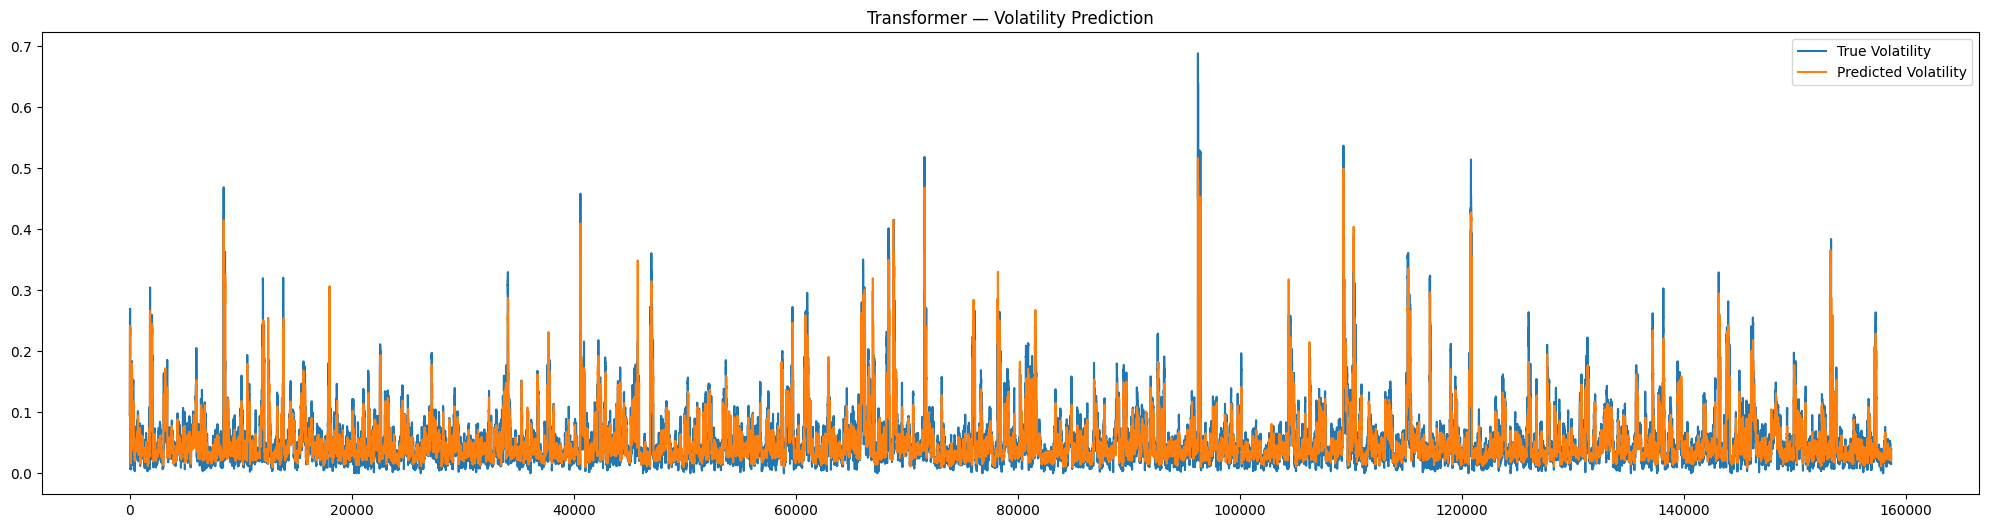

In [41]:
plt.figure(figsize=(25, 6))
plt.plot(actuals, label="True Volatility")
plt.plot(predictions, label="Predicted Volatility")
plt.legend()
plt.title("Transformer — Volatility Prediction")
plt.show()